In [2]:
import torch
import os
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
listdirs = ["Healthy", "Motor_1_Steady_state_error", "Motor_1_Stuck", "Motor_2_Steady_state_error", "Motor_2_Stuck", "Motor_3_Steady_state_error", "Motor_3_Stuck", "Motor_4_Steady_state_error", "Motor_4_Stuck"]
path = "training_csv/"
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [42]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, training_ratio:float, training:bool, path, directories_list, backend):
        super().__init__()
        self.path = path
        self.backend = backend
        self.training_ratio = training_ratio
        self.directories_list = directories_list
        self.simulations = []
        self.classes = []

        for i, folder in enumerate(self.directories_list):
            folderpath = os.path.join(path, folder)
            files = os.listdir(folderpath)
            number_files = len(files)
            for n, file in enumerate(files):
                if n < self.training_ratio * number_files and training:
                    open_file = pd.read_csv(os.path.join(folderpath, file))
                    tensor = torch.tensor(open_file.values, dtype=torch.float32)
                    tensor[:,3:] -= tensor[:,:3]
                    standardized_tensor = (tensor - tensor.mean(dim=0, keepdim=True))/tensor.std(dim=0, keepdim=True)
                    self.simulations.append(standardized_tensor)
                    self.classes.append(torch.nn.functional.one_hot(torch.tensor([i]), num_classes=9)[0].type(torch.float16))
                elif n >= self.training_ratio * number_files and not training:
                    open_file = pd.read_csv(os.path.join(folderpath, file))
                    tensor = torch.tensor(open_file.values, dtype=torch.float32)
                    tensor[:,3:] -= tensor[:,:3]
                    standardized_tensor = (tensor - tensor.mean(dim=0, keepdim=True))/tensor.std(dim=0, keepdim=True)
                    self.simulations.append(standardized_tensor)
                    self.classes.append(torch.nn.functional.one_hot(torch.tensor([i]), num_classes=9)[0].type(torch.float16))
        
        self.simulations = torch.stack(self.simulations)
        self.classes = torch.stack(self.classes)

    def __len__(self):
        return len(self.simulations)
    
    def __getitem__(self, index):
        return (self.simulations[index], self.classes[index])
    
training_set = dataset(training_ratio=0.9, training=True, path=path, directories_list=listdirs, backend=device)
trainingloader = torch.utils.data.DataLoader(training_set, shuffle=True, batch_size=32)

testing_set = dataset(training_ratio=0.9, training=False, path=path, directories_list=listdirs, backend=device)
testingloader = torch.utils.data.DataLoader(testing_set, batch_size=128, shuffle=False)

In [12]:
print(training_set.classes.shape, training_set.simulations.shape, training_set.classes.shape, training_set.simulations.shape)

torch.Size([3240, 9]) torch.Size([3240, 999, 6]) torch.Size([3240, 9]) torch.Size([3240, 999, 6])


In [47]:
class LSTM_model(nn.Module):
    def __init__(self, hidden_size, backend):
        super().__init__()
        self.hidden_size = hidden_size
        self.backend = backend

        self.LSTM = nn.LSTM(input_size=6, hidden_size=self.hidden_size, dropout=0.1, device=self.backend, batch_first=True, num_layers=2)
        self.Linear = nn.Linear(in_features=self.hidden_size, out_features=9, device=self.backend)

    def forward(self, x):
        x = self.LSTM(x)[0][:,-1]
        x = self.Linear(x)
        return x
    
Lstm = LSTM_model(100, device)

In [51]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Lstm.parameters(), lr=1E-3)
epochs = 250 - 14
patience = 10
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.5, patience=patience)


In [ ]:
for e in range(epochs):
    for i, data in enumerate(trainingloader):
        optimizer.zero_grad()
        predictions = Lstm.forward(data[0].to(device))
        true_results = data[1].to(device)

        cost = loss_function(predictions, true_results)

        cost.backward()

        optimizer.step()

    print(f"Epoch : {e+1}, training cost : {cost}")

    Lstm.eval()
    with torch.no_grad():
        accurate = 0
        test_predictions = Lstm.forward(testing_set.simulations.to(device))
        testing_set.classes = testing_set.classes.to(device)
        for n, prediction in enumerate(test_predictions):
            if torch.argmax(prediction) == torch.argmax(testing_set.classes[n]):
                accurate += 1
        cost = loss_function(test_predictions, testing_set.classes)
        print(f"Epoch : {e+1}, testing cost : {cost}, accuracy : {accurate/len(testing_set)*100}%")
        scheduler.step(cost)


Epoch : 1, training cost : 1.3453145027160645
Epoch : 1, testing cost : 1.8513163328170776, accuracy : 33.88888888888889%
Epoch : 2, training cost : 0.7805802226066589
Epoch : 2, testing cost : 1.9214913845062256, accuracy : 30.277777777777775%
Epoch : 3, training cost : 1.9239333868026733
Epoch : 3, testing cost : 1.96316659450531, accuracy : 31.944444444444443%
Epoch : 4, training cost : 1.4180281162261963
Epoch : 4, testing cost : 2.018843173980713, accuracy : 25.27777777777778%
Epoch : 5, training cost : 0.9065353870391846
Epoch : 5, testing cost : 1.9244189262390137, accuracy : 28.888888888888886%
Epoch : 6, training cost : 1.398040771484375
Epoch : 6, testing cost : 2.2277565002441406, accuracy : 19.444444444444446%
Epoch : 7, training cost : 1.0046190023422241
Epoch : 7, testing cost : 2.305088520050049, accuracy : 26.944444444444443%
Epoch : 8, training cost : 1.250449776649475
Epoch : 8, testing cost : 1.9276750087738037, accuracy : 27.22222222222222%


In [ ]:
Lstm.zero_grad()
VP = FP = FN = np.zeros(9)
correct = 0
for i, data in enumerate(testingloader):
    predictions = Lstm.forward(data[0])

    for n, prediction in enumerate(predictions):
        response = torch.argmax(prediction)
        true_result = torch.argmax(data[1][n])
        if response == true_result:
            VP[true_result] += 1
            correct += 1
        else:
            FP[response] += 1
            FN[true_result] += 1

precision = VP/(VP+FP)
recall = VP/(VP+FN)
print(f"Accuracy : {correct/360*100} ‰", f"F1 score : {2*precision*recall/(precision+recall)}")

Accuracy : 11.11111111111111 ‰ F1 score : [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


In [ ]:
torch.save(Lstm, "LSTM_model_30-03")

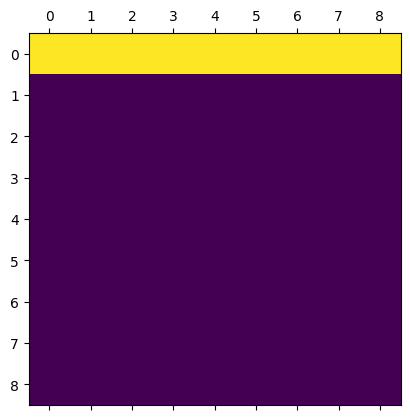

In [ ]:
results = np.zeros((9, 9))

for data in testingloader:
    predictions = Lstm.forward(data[0])

    for n, prediction in enumerate(predictions):
        results[torch.argmax(prediction)][torch.argmax(data[1][n])] += 1

plt.matshow(results)